# Organizational Mining

In [1]:
import pandas as pd
import numpy as np
from datetime import date
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#!pip install pm4py --user
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.importer.xes import importer as xes_importer

# process mining 
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.algo.discovery.footprints import algorithm as footprints_discovery


# viz
from pm4py.visualization.petri_net import visualizer as pn_visualizer
from pm4py.visualization.footprints import visualizer as fp_visualizer
from pm4py.visualization.transition_system import visualizer as ts_visualizer
from pm4py.visualization.process_tree import visualizer as pt_visualizer
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer
from pm4py.visualization.dfg import visualizer as dfg_visualization

# conformance
from pm4py.algo.conformance.footprints import algorithm as fp_conformance
from pm4py import conformance_diagnostics_token_based_replay
from pm4py.algo.conformance.alignments.edit_distance import algorithm as logs_alignments

# misc 
from pm4py.objects.petri_net.utils import reachability_graph
from pm4py.objects.conversion.process_tree import converter as pt_converter
from pm4py.objects.petri_net.obj import PetriNet, Marking

import pm4py

### Read event log

In [1]:
fn = 'request_data.csv'
events = pd.read_csv(fn,sep=';')
events['Timestamp'] = pd.to_datetime(events['Timestamp'],format='%d-%m-%Y:%H.%M')

NameError: name 'pd' is not defined

In [4]:
activitynames = {'register_request': 'a_register_request',
                 'examine_thoroughly': 'b_examine_thoroughly',
                    'examine_casually': 'c_examine_casually',
                    'check_ticket': 'd_check_ticket',
                    'decide': 'e_decide',
                    'reinitiate_request': 'f_reinitiate_request',
                    'pay_compensation': 'g_pay_compensation',
                    'reject_request': 'h_reject_request'
                 }

In [5]:
# rename values in row 'Activity' to the values in activitynames
events['Activity'] = events['Activity'].map(activitynames)

### Resource Activity Matrix

In [6]:
# Resource Activity Matrix
resource_activity_matrix = events.groupby("Activity")["Resource"].value_counts().unstack().fillna(0).transpose()
print(resource_activity_matrix)

Activity  a_register_request  b_examine_thoroughly  c_examine_casually  \
Resource                                                                 
Ellen                    1.0                   0.0                 1.0   
Mike                     2.0                   0.0                 3.0   
Pete                     3.0                   0.0                 1.0   
Sara                     0.0                   0.0                 0.0   
Sean                     0.0                   2.0                 0.0   
Sue                      0.0                   2.0                 0.0   

Activity  d_check_ticket  e_decide  f_reinitiate_request  g_pay_compensation  \
Resource                                                                       
Ellen                2.0       0.0                   0.0                 2.0   
Mike                 4.0       0.0                   0.0                 1.0   
Pete                 3.0       0.0                   0.0                 0.0   
Sara   

In [7]:
# normalize resource activity matrix by the number of cases
num_cases = len(events['Case_ID'].unique())
resource_activity_matrix_norm = resource_activity_matrix.div(num_cases)
resource_activity_matrix_norm

Activity,a_register_request,b_examine_thoroughly,c_examine_casually,d_check_ticket,e_decide,f_reinitiate_request,g_pay_compensation,h_reject_request
Resource,,,,,,,,
Ellen,0.166667,0.000000,0.166667,0.333333,0.0,0.0,0.333333,0.166667
Mike,0.333333,0.000000,0.500000,0.666667,0.0,0.0,0.166667,0.166667
Pete,0.500000,0.000000,0.166667,0.500000,0.0,0.0,0.000000,0.166667
Sara,0.000000,0.000000,0.000000,0.000000,1.5,0.5,0.000000,0.000000
Sean,0.000000,0.333333,0.000000,0.000000,0.0,0.0,0.000000,0.000000
Sue,0.000000,0.333333,0.000000,0.000000,0.0,0.0,0.000000,0.000000


### Clustering of resource-activity profiles based on Manhattan distances

In [8]:
# calculate manhattan distances between resources
from scipy.spatial.distance import pdist, squareform
distances = pdist(resource_activity_matrix_norm, metric='cityblock')
distances = squareform(distances)
distances = pd.DataFrame(distances, index=resource_activity_matrix_norm.index, columns=resource_activity_matrix_norm.index)
distances

Resource,Ellen,Mike,Pete,Sara,Sean,Sue
Resource,,,,,,
Ellen,0.000000,1.000000,0.833333,3.166667,1.500000,1.500000
Mike,1.000000,0.000000,0.833333,3.833333,2.166667,2.166667
Pete,0.833333,0.833333,0.000000,3.333333,1.666667,1.666667
Sara,3.166667,3.833333,3.333333,0.000000,2.333333,2.333333
Sean,1.500000,2.166667,1.666667,2.333333,0.000000,0.000000
Sue,1.500000,2.166667,1.666667,2.333333,0.000000,0.000000


In [9]:
# invert distances to get similarity ignoring diagonal
similarity_manhattan = 1/distances
similarity_manhattan = similarity_manhattan - np.diag(np.diag(similarity_manhattan))
similarity_manhattan



Resource,Ellen,Mike,Pete,Sara,Sean,Sue
Resource,,,,,,
Ellen,NaN,1.000000,1.2,0.315789,0.666667,0.666667
Mike,1.000000,NaN,1.2,0.260870,0.461538,0.461538
Pete,1.200000,1.200000,NaN,0.300000,0.600000,0.600000
Sara,0.315789,0.260870,0.3,NaN,0.428571,0.428571
Sean,0.666667,0.461538,0.6,0.428571,NaN,inf
Sue,0.666667,0.461538,0.6,0.428571,inf,NaN


In [10]:
# replace inf with 2 (arbitrary strongest similarity)
similarity_manhattan.replace(np.inf, 2, inplace=True)




In [11]:
# replace nan with 0
similarity_manhattan.fillna(0, inplace=True)

In [12]:
# replace all values < 1 with 0
similarity_manhattan[similarity_manhattan < 1] = 0


In [13]:
# depict distances as network with networkx
#!pip install --upgrade networkx # this needs to be run only once if error "module 'matplotlib.cbook' has no attribute 'iterable'" appears
import networkx as nx
G = nx.from_numpy_matrix(similarity_manhattan.values)    
G = nx.relabel_nodes(G, dict(zip(range(len(similarity_manhattan.index)), similarity_manhattan.index)))
#nx.draw(G, with_labels=True, node_size=1000, node_color='lightblue', font_size=8, width=list(nx.get_edge_attributes(G,'weight').values()))
nx.draw(G, with_labels=True, node_size=500, font_size=8)



AttributeError: module 'networkx' has no attribute 'from_numpy_matrix'

In [57]:
# cluster analysis on resource_activity_matrix_norm
from sklearn.cluster import AgglomerativeClustering
clustering = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='average').fit(resource_activity_matrix_norm)
print(list(zip(list(resource_activity_matrix_norm.index), clustering.labels_)))

[('Ellen', 0), ('Mike', 0), ('Pete', 0), ('Sara', 1), ('Sean', 2), ('Sue', 2)]


### Other distance measures

In [58]:
# calculate euclidean distances between resources
from scipy.spatial.distance import pdist, squareform
distances_eucl = pdist(resource_activity_matrix_norm, metric='euclidean')
distances_eucl = squareform(distances_eucl)
distances_eucl = pd.DataFrame(distances_eucl, index=resource_activity_matrix_norm.index, columns=resource_activity_matrix_norm.index)
distances_eucl

Resource,Ellen,Mike,Pete,Sara,Sean,Sue
Resource,,,,,,
Ellen,0.000000,0.527046,0.500000,1.674979,0.645497,0.645497
Mike,0.527046,0.000000,0.440959,1.833333,0.986013,0.986013
Pete,0.500000,0.440959,0.000000,1.748015,0.816497,0.816497
Sara,1.674979,1.833333,1.748015,0.000000,1.615893,1.615893
Sean,0.645497,0.986013,0.816497,1.615893,0.000000,0.000000
Sue,0.645497,0.986013,0.816497,1.615893,0.000000,0.000000


In [59]:
# calculate correlation distance between resources
from scipy.spatial.distance import pdist, squareform
distances_corr = pdist(resource_activity_matrix_norm, metric='correlation')
distances_corr = squareform(distances_corr)
distances_corr = pd.DataFrame(distances_corr, index=resource_activity_matrix_norm.index, columns=resource_activity_matrix_norm.index)
distances_corr

Resource,Ellen,Mike,Pete,Sara,Sean,Sue
Resource,,,,,,
Ellen,0.000000,0.275337,0.477024,1.560449,1.423659,1.423659
Mike,0.275337,0.000000,0.203024,1.488046,1.368928,1.368928
Pete,0.477024,0.203024,0.000000,1.408248,1.308607,1.308607
Sara,1.560449,1.488046,1.408248,0.000000,1.188982,1.188982
Sean,1.423659,1.368928,1.308607,1.188982,0.000000,0.000000
Sue,1.423659,1.368928,1.308607,1.188982,0.000000,0.000000


### resource case matrix

In [60]:
# Resource Case Matrix (we are only interested in whether or not a resource was involved in a case)
resource_case_matrix = events.groupby("Case_ID")["Resource"].value_counts().unstack().fillna(0).transpose()
resource_case_matrix

Case_ID,1,2,3,4,5,6
Resource,,,,,,
Ellen,0.0,1.0,2.0,1.0,2.0,1.0
Mike,1.0,2.0,1.0,1.0,3.0,3.0
Pete,2.0,1.0,2.0,1.0,2.0,0.0
Sara,1.0,1.0,3.0,1.0,5.0,1.0
Sean,0.0,0.0,1.0,1.0,0.0,0.0
Sue,1.0,0.0,0.0,0.0,1.0,0.0


In [61]:
resource_case_matrix[resource_case_matrix>1]=1
resource_case_matrix

Case_ID,1,2,3,4,5,6
Resource,,,,,,
Ellen,0.0,1.0,1.0,1.0,1.0,1.0
Mike,1.0,1.0,1.0,1.0,1.0,1.0
Pete,1.0,1.0,1.0,1.0,1.0,0.0
Sara,1.0,1.0,1.0,1.0,1.0,1.0
Sean,0.0,0.0,1.0,1.0,0.0,0.0
Sue,1.0,0.0,0.0,0.0,1.0,0.0


### Clustering of resource-case profiles based on Euclidian distances

In [62]:
# calculate euclidean distances between resources for resource-case profiles
distances_case_eucl = pdist(resource_case_matrix, metric='euclidean')
distances_case_eucl = squareform(distances_case_eucl)
distances_case_eucl = pd.DataFrame(distances_case_eucl, index=resource_case_matrix.index, columns=resource_case_matrix.index)
distances_case_eucl

Resource,Ellen,Mike,Pete,Sara,Sean,Sue
Resource,,,,,,
Ellen,0.000000,1.0,1.414214,1.0,1.732051,2.236068
Mike,1.000000,0.0,1.000000,0.0,2.000000,2.000000
Pete,1.414214,1.0,0.000000,1.0,1.732051,1.732051
Sara,1.000000,0.0,1.000000,0.0,2.000000,2.000000
Sean,1.732051,2.0,1.732051,2.0,0.000000,2.000000
Sue,2.236068,2.0,1.732051,2.0,2.000000,0.000000


In [63]:
# calculate similarity by invertion of distances_case_eucl (ignore diagonal)
similarity_case_eucl = 1/distances_case_eucl
similarity_case_eucl

Resource,Ellen,Mike,Pete,Sara,Sean,Sue
Resource,,,,,,
Ellen,inf,1.0,0.707107,1.0,0.57735,0.447214
Mike,1.000000,inf,1.000000,inf,0.50000,0.500000
Pete,0.707107,1.0,inf,1.0,0.57735,0.577350
Sara,1.000000,inf,1.000000,inf,0.50000,0.500000
Sean,0.577350,0.5,0.577350,0.5,inf,0.500000
Sue,0.447214,0.5,0.577350,0.5,0.50000,inf


In [64]:

similarity_case_eucl = similarity_case_eucl - np.diag(np.diag(similarity_case_eucl))
# replace inf with 2 (arbitrary strongest similarity)
similarity_case_eucl.replace(np.inf, 2, inplace=True)
# replace nan with 0
similarity_case_eucl.fillna(0, inplace=True)
# replace all values < .6 with 0
similarity_case_eucl[similarity_case_eucl < .6] = 0
similarity_case_eucl


Resource,Ellen,Mike,Pete,Sara,Sean,Sue
Resource,,,,,,
Ellen,0.000000,1.0,0.707107,1.0,0.0,0.0
Mike,1.000000,0.0,1.000000,2.0,0.0,0.0
Pete,0.707107,1.0,0.000000,1.0,0.0,0.0
Sara,1.000000,2.0,1.000000,0.0,0.0,0.0
Sean,0.000000,0.0,0.000000,0.0,0.0,0.0
Sue,0.000000,0.0,0.000000,0.0,0.0,0.0


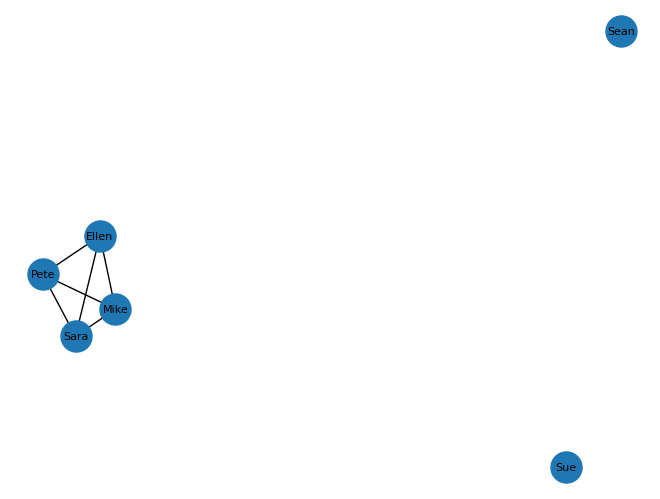

In [65]:
# depict distances as network with networkx
G_case = nx.from_numpy_matrix(similarity_case_eucl.values)    
G_case = nx.relabel_nodes(G_case, dict(zip(range(len(similarity_case_eucl.index)), similarity_case_eucl.index)))
nx.draw(G_case, with_labels=True, node_size=500, font_size=8)

In [66]:
# cluster analysis on resource_activity_matrix_norm
clustering_case = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='average').fit(resource_case_matrix)
print(list(zip(list(resource_case_matrix.index), clustering_case.labels_)))

[('Ellen', 0), ('Mike', 0), ('Pete', 0), ('Sara', 0), ('Sean', 2), ('Sue', 1)]
